In [1]:
import os, pickle
from datetime import datetime, date
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import itertools
from numpy.fft import *
from scipy.stats import gaussian_kde
import scipy
import time

In [2]:
plt.rcParams.update({'font.size': 8})
plt.style.use('fast')

In [3]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    newNames = {'SITE': 'Site', \
                    'PLOT_ID':'PlotID',\
                    'nlcd':'NLCD_class',\
                    'clumping_index_Miller_understoryest' : 'clumping_Miller_down' , \
                    'clumping_index_Miller_understoryerror': 'clumping_Miller_down_err' , \
                    'clumping_index_Miller_overstoryest': 'clumping_Miller_up', \
                    'clumping_index_Miller_overstoryerror': 'clumping_Miller_up_err', \
                    'clumping_index_Warren_understoryest': 'clumping_Warren_down', \
                    'clumping_index_Warren_understoryerror': 'clumping_Warren_down_err', \
                    'clumping_index_Warren_overstoryest': 'clumping_Warren_up', \
                    'clumping_index_Warren_overstoryerror': 'clumping_Warren_up_err' , \
                    'datetime': 'Date', \
                    'understory_flag': 'down_flag' , \
                    'FIPAR_understoryest': 'fAPAR_down', \
                    'FIPAR_understoryerror': 'fAPAR_down_err', \
                    'FIPAR_overstoryest': 'fAPAR_up', \
                    'FIPAR_overstoryerror':'fAPAR_up_err', \
                    'FCOVER_understoryest': 'fCOVER_down', \
                    'FCOVER_understoryerror':'fCOVER_down_err', \
                    'FCOVER_overstoryest':'fCOVER_up', \
                    'FCOVER_overstoryerror': 'fCOVER_up_err', \
                    
                    'true_LAI_Miller_understoryest':'PAI_Miller_down', \
                    'true_LAI_Miller_understoryerror':'PAI_Miller_down_err', \
                    'true_LAI_Miller_overstoryest':'PAI_Miller_up', \
                    'true_LAI_Miller_overstoryerror':'PAI_Miller_up_err', \
                    'true_LAI_Warren_understoryest':'PAI_Warren_down', \
                    'true_LAI_Warren_understoryerror':'PAI_Warren_down_err', \
                    'true_LAI_Warren_overstoryest':'PAI_Warren_up', \
                    'true_LAI_Warren_overstoryerror':'PAI_Warren_up_err', \
                    
                    'effective_LAI_Miller_understoryest':'PAIe_down', \
                    'effective_LAI_Miller_understoryerror':'PAIe_down_err', \
                    'effective_LAI_Miller_overstoryest':'PAIe_up', \
                    'effective_LAI_Miller_overstoryerror':'PAIe_up_err', \
                    'effective_LAI_Warren_understoryest':'PAIe_Warren_down', \
                    'effective_LAI_Warren_understoryerror':'PAIe_Warren_down_err', \
                    'effective_LAI_Warren_overstoryest':'PAIe_Warren_up', \
                    'effective_LAI_Warren_overstoryerror':'PAIe_Warren_up_err', \
                    'PLOT_ID':'PLOT_ID', \
                    'timeStart':'timeStart', \
                    'overstory_flag':'up_flag', \
                    'combined_flag':'combined_flag'}                   
    return  siteDF.rename(columns = newNames)

In [4]:
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for NEON sites
    # use initial fixed ratio for all sites based on shrubs 
    if 'NEON' in np.unique(samplesDF['network']):
        samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio'] = 0.10
        samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio_std'] = 0.11
    
        # use fixed ratio for needeleaf sitesnumpy
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  
    
        # use fixed ratio for  broadleaf sites
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11
    
        # use fixed ratio for mixed forest
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
        samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11
    return (samplesDF)

In [5]:
def parseSampleFile(samplesDF,variableName):
# clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    samplesDF = renameColumns(samplesDF)
    samplesDF['network']='NEON'
    #samplesDF=rename_nlcd_class(samplesDF)
    
    if variableName == 'LAI' :
        pai_algo='Miller' # choices: ['Miller','']
        samplesDF['PAI_up']=samplesDF['PAI_%s_up'%(pai_algo)]
        samplesDF['PAI_up_err']=samplesDF['PAI_%s_up_err'%(pai_algo)]
        samplesDF['PAI_down']=samplesDF['PAI_%s_down'%(pai_algo)]
        samplesDF['PAI_down_err']=samplesDF['PAI_%s_down_err'%(pai_algo)]
        
        samplesDF = estimateWAItoPAIratio(samplesDF)
        columns=['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']
        #samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values 
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF[columns] = samplesDF[columns].replace(-999, 0)
        #samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)
         
        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5) 
        
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)     

    elif variableName == 'fCOVER' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        columns=['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']
        #samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values  
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF [columns]= samplesDF[columns].replace(-999, 0)
        #samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  

    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        columns=['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']
        #samplesDF[columns]=correct_cell_values(samplesDF[columns]) #-------------> correct some wrong values  
        samplesDF[columns] = samplesDF[columns].apply(pd.to_numeric)
        samplesDF [columns]= samplesDF[columns].replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        #samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']sensor1
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')     
    return samplesDF

In [6]:
def time_serie_filter(df,timecol,datacol,errcol,maxerr):
    df['QC']=False 
    df['avg']=np.nan
    filter_delta=15

    for ff in df.index:
        date_min,date_max= df[timecol][ff]-filter_delta,df[timecol][ff]+filter_delta
        dfsub=df[(df['time_int']>=date_min) & (df['time_int']<=date_max)]
        df.loc[ff,'avg'] = dfsub[datacol].median() 
        idx=list(dfsub.index)
        if (len(dfsub)>2) & (ff>idx[0]) & (ff<idx[-1]): 
            act,bef,aft=dfsub[datacol][ff],dfsub[datacol][idx[idx.index(ff)-1]],dfsub[datacol][idx[idx.index(ff)+1]]
            Q1=(bef-act)*(aft-act)>0
            Q2=np.abs(bef-act)>np.max([maxerr,df[errcol][ff]])
            Q3=np.abs(aft-act)>np.max([maxerr,df[errcol][ff]])
            df.loc[ff,'QC'] = Q1*Q2*Q3
    return df

In [7]:
def cols_name(sensor):
    cols=[sensor+'_total',sensor+'_total_err']
    if sensor=='LAI':
        cols=[sensor+'e_total',sensor+'e_total_err']
    return cols

In [27]:
def plot_filtered_time_serie(sampleDF,var_max_err,outpath=None):
    nlcd=sampleDF['nlcd'].values[0] 
    # fig,ax= plt.subplots(3,1,figsize=(6,7),constrained_layout = False,dpi=150)
    # fig.patch.set_facecolor('white')
    fig,ax= plt.subplots(3,1,figsize=(6,6),constrained_layout = True,dpi=150)
    fig.patch.set_facecolor('white')
    fig.suptitle(f'Plot ID: %s (%s)'%(plot_id,nlcd),fontsize=8, y=0.95) 
    
    outliers=pd.DataFrame()
    NB={}
    NG={}
    for ii,var in enumerate(list(var_max_err.keys())):
        prefix='_total'
        df=parseSampleFile(sampleDF,var)[['system:time_start','PLOT_ID','NLCD_class',cols_name(var)[0],cols_name(var)[1],'combined_flag']]
        NB.update({var:len(df)})
        df=df[df[cols_name(var)[0]]>0].sort_values(by='system:time_start').reset_index(drop=True) 
        df['time_int']=pd.DatetimeIndex(df['system:time_start']).to_julian_date()
        df=time_serie_filter(df,'time_int',cols_name(var)[0],cols_name(var)[1],var_max_err[var])
        NG.update({var:df['QC'].sum()})
        
        dft0=df[df['combined_flag']>0]
        dft=df[df['QC']==True]
        ax[ii].errorbar(df['system:time_start'],df[cols_name(var)[0]],df[cols_name(var)[1]],color='black', ls='none', marker='o',markersize=2, capsize=1, capthick=1, ecolor='grey')
        ax[ii].scatter(dft['system:time_start'],dft[cols_name(var)[0]],s=60, facecolors='none', edgecolors='r',label='Detected outlier')
        #ax[ii].scatter(dft0['system:time_start'],dft0[cols_name(var)[0]],s=60, facecolors='none', edgecolors='y',label='NEON data combined flag') 
         
        ax[ii].set_xlim([date(2015, 1, 1),date(2023, 1, 1)])
        ax[ii].set_ylim([0,vmax[var][1]])
        ax[ii].set_xlabel(f'Date')
        ax[ii].set_ylabel(f'{var}')
        ax[ii].grid(which='both',linestyle=':', linewidth=0.5)
        ax[ii].legend(loc="upper right",bbox_to_anchor=(1.01,0.98), frameon=False)
        
        ax[ii].annotate(f'#Samples: {NB[var]}', xy=(0.05, 1.05), xycoords='axes fraction',color='black')
        ax[ii].annotate(f'#Outliers: {NG[var]}', xy=(0.25, 1.05),xycoords='axes fraction',color='red') 
        if not dft.empty:
            dft.loc[:,'QC']=var[:]    
            outliers=pd.concat([outliers,dft[['system:time_start','PLOT_ID','NLCD_class','QC']].rename(columns={'NLCD_class': "nlcd", "QC": "Variable"})],axis=0)       
    if outpath:
        nlcd_path=os.path.join(outpath,nlcd)
        if not os.path.isdir(nlcd_path):
            os.mkdir(nlcd_path)  
        plt.savefig(os.path.join(nlcd_path,'%s_%s_LAI_fCOVER_fAPAR_time_series_%s.png'%(nlcd,"{0:0=3d}".format(NB[var]),plot_id)))
        plt.cla
        plt.clf
    plt.close(fig)              
    return nlcd,NB,NG,outliers

### 1- Show sample of noised time series 

In [28]:
fn="C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Landsat-Validation-paper/data/0_NEON_sites/NEON_2013-22_RMs_updated_parsed.csv"
data=pd.read_csv(fn)
samples_noised_series=['GUAN_054','LAJA_065','HARV_050','TAEK_046','SOAP_058','DEJU_052','SOAP_054','PUUM_039','TALL_049','BLAN_034',]
data['system:time_start'] = pd.to_datetime(data['system:time_start'], format="%d/%m/%Y")
vmax={'LAI':[0,5],'fCOVER':[0,1],'fAPAR':[0,1]} 
var_max_err={'LAI':1.5,'fCOVER':0.2,'fAPAR':0.2}

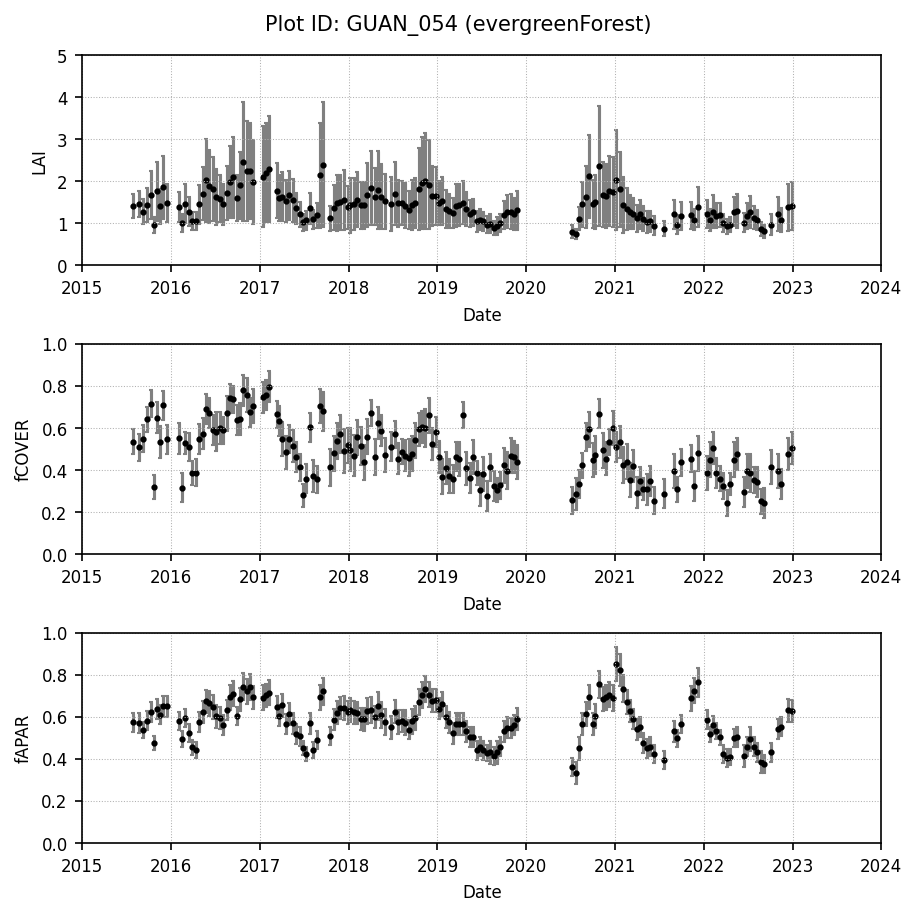

In [29]:
plot_id=samples_noised_series[0]
sampleDF=data[data['PLOT_ID']==plot_id]
fig,ax= plt.subplots(3,1,figsize=(6,6),constrained_layout = True,dpi=150)
fig.patch.set_facecolor('white')
fig.suptitle(f'Plot ID: %s (%s)'%(plot_id,sampleDF['nlcd'].values[0]),fontsize=10)  

for ii,var in enumerate(['LAI','fCOVER','fAPAR']):
    prefix='_total'
    df=parseSampleFile(sampleDF,var)[['system:time_start',cols_name(var)[0],cols_name(var)[1],'combined_flag']]
    df=df[df[cols_name(var)[0]]>0].sort_values(by='system:time_start')
    #dft0=df[df['combined_flag']>0]
    
    ax[ii].errorbar(df['system:time_start'],df[cols_name(var)[0]],df[cols_name(var)[1]],color='black', ls='none', marker='o',markersize=2, capsize=1, capthick=1, ecolor='grey',zorder=0)
    #ax[ii].scatter(dft0['system:time_start'],dft0[cols_name(var)[0]],s=60, facecolors='none', edgecolors='m') 
    
    ax[ii].set_xlim([date(2015, 1, 1),date(2024, 1, 1)])
    ax[ii].set_ylim([0,vmax[var][1]])
    ax[ii].set_xlabel(f'Date')
    ax[ii].set_ylabel(f'{var}')
    ax[ii].grid(which='both',linestyle=':', linewidth=0.5)

### 3. Vegetation variables estimates filtering

In [30]:
outpath='C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Landsat-Validation-paper/0_paper/figures/Reference_measures_filtering'
if not os.path.isdir(outpath):
    os.makedirs(outpath)

In [31]:
plot_id=samples_noised_series[0]
sampleDF=data[data['PLOT_ID']==plot_id]
sampleDF=sampleDF[(sampleDF['system:time_start'].dt.year>2015) & sampleDF['system:time_start'].dt.year<2024] 
out=plot_filtered_time_serie(sampleDF,var_max_err,outpath)

### 4. Testing for the different plots

In [32]:
nsamples_dict={'LAI':{},'fCOVER':{},'fAPAR':{}}
outliersDF=pd.DataFrame()
for plot_id in np.unique(data['PLOT_ID']):
    sampleDF=data[data['PLOT_ID']==plot_id]
    sampleDF=sampleDF[(sampleDF['system:time_start'].dt.year>2010) & sampleDF['system:time_start'].dt.year<2026] 
    if len(sampleDF)>10:
        nlcd,NB,NG,outliers=plot_filtered_time_serie(sampleDF,var_max_err,outpath) 
        outliersDF=pd.concat([outliersDF,outliers])
    else:
        nlcd=sampleDF['nlcd'].values[0] 
        NB={'LAI': len(sampleDF), 'fCOVER': len(sampleDF), 'fAPAR': len(sampleDF)}
        NG={'LAI': 0, 'fCOVER': 0, 'fAPAR': 0}
        print('\r%s : Not fitered - Low number of samples (%s)\t'%(plot_id,len(sampleDF)),end='', flush=True)
        
    for var in NG.keys():
        if nlcd not in list(nsamples_dict[var].keys()):
            nsamples_dict[var].update({nlcd:{'Total samples':0,'Filtered samples':0}})   
        TS=nsamples_dict[var][nlcd]['Total samples']+NB[var]
        FS=nsamples_dict[var][nlcd]['Filtered samples']+NG[var]
        nsamples_dict[var].update({nlcd:{'Total samples':TS,'Filtered samples':FS}})

for var in NG.keys():
    nsamples_dict[var]=(pd.DataFrame(nsamples_dict[var])).T
    nsamples_dict[var].loc['total',:]=nsamples_dict[var].sum(axis=0)
    nsamples_dict[var]['Filtered samples (%)']=100*(nsamples_dict[var]['Filtered samples']/nsamples_dict[var]['Total samples']).round(4)
print('Done')

YELL_020 : Not fitered - Low number of samples (1)		Data filtering summry:



In [47]:
outliersDFsummary=nsamples_dict['LAI'].join(nsamples_dict['fCOVER'],lsuffix='LAI',rsuffix='_fCOVER').join(nsamples_dict['fAPAR'],rsuffix='_fAPAR')
outliersDFsummary

,Total samplesLAI,Filtered samplesLAI,Filtered samples (%)LAI,Total samples_fCOVER,Filtered samples_fCOVER,Filtered samples (%)_fCOVER,Total samples,Filtered samples,Filtered samples (%)
evergreenForest,3427.0,3.0,0.09,3427.0,30.0,0.88,3427.0,16.0,0.47
grasslandHerbaceous,2101.0,1.0,0.05,2101.0,4.0,0.19,2101.0,3.0,0.14
shrubScrub,1704.0,0.0,0.00,1704.0,1.0,0.06,1704.0,1.0,0.06
mixedForest,639.0,1.0,0.16,639.0,1.0,0.16,639.0,1.0,0.16
sedgeHerbaceous,126.0,0.0,0.00,126.0,0.0,0.00,126.0,0.0,0.00
emergentHerbaceousWetlands,79.0,0.0,0.00,79.0,0.0,0.00,79.0,0.0,0.00
deciduousForest,3923.0,19.0,0.48,3923.0,28.0,0.71,3923.0,31.0,0.79
pastureHay,934.0,16.0,1.71,934.0,55.0,5.89,934.0,48.0,5.14
cultivatedCrops,702.0,2.0,0.28,702.0,16.0,2.28,702.0,16.0,2.28
woodyWetlands,326.0,2.0,0.61,326.0,2.0,0.61,326.0,2.0,0.61


In [48]:
outliersDFsummary.to_csv(os.path.join(outpath,os.path.basename(fn).replace('.csv','_outliers_summary.csv')))

In [49]:
outliersDF.to_csv(os.path.join(outpath,os.path.basename(fn).replace('.csv','_outliers.csv')))

In [50]:
os.path.join(outpath,os.path.basename(fn).replace('.csv','_outliers.csv'))

'C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Landsat-Validation-paper/0_paper/figures/Reference_measures_filtering\\NEON_2013-22_RMs_updated_parsed_outliers.csv'